In [1]:
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm

from settings import file_names
from graph import make_friends_graph, make_user_business_bipartite_graph
from helpers import split_train_validation_test

In [2]:
# Helper Functions
# A helper funtion to assign communities
def assign_communities(community, df, name, G, col='user_id'):
    # Create a new df
    df = df.copy()
    
    # Create a new column for communities
    df[name] = 0
    
    for i, com in enumerate(community):
        
        # Get node indices
        com = G.vs[com][G.vs.attribute_names()[-1]]
        
        mask = df[col].isin(com)
        df.loc[mask, name] = i 
        
    return df

# A helper function to make mean encodings
def mean_encoding(data, col_1, col_2='rating'):
    mean_encoding = data[data['set']=='train'].groupby(col_1)[col_2].mean().reset_index()
    mean_encoding.columns = [col_1, col_1+'_'+col_2]
    data = data.merge(mean_encoding, on=col_1, how='left')
    
    return data

In [3]:
# Read Data
df_biz = pd.read_csv(file_names['toronto_businesses'])
df_rev = pd.read_csv(file_names['toronto_reviews_without_text'])
G_users = make_friends_graph('igraph')

# Designate training, validation and test review data
df_train, df_val, df_test = split_train_validation_test(df_rev)
df_train['set'] = 'train'
df_val['set'] = 'val'
df_test['set'] = 'test'
df = pd.concat([df_train, df_val, df_test], axis=0)

# 1. Feature Engineering

Quite messy for the time being, I will make a cleaner one after it is finalized.

## 1.1 Business

In [4]:
# Select relevant columns
cols = ['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories']
df_biz = df_biz[cols]

# Clean the attributes column - Undone
df_biz['attributes'] = df_biz['attributes'].map(eval, na_action='ignore')
df_biz = df_biz.drop('attributes', axis=1)

# Clean the categories column
df_biz['categories'] = df_biz['categories'].str.split(', ')

# Keep only categories that have at least 300 samples
temp = df_biz.pop('categories').explode()
temp = pd.crosstab(temp.index, temp)
mask = temp.sum(axis=0)
mask = (mask[mask>=300]).index
df_biz = pd.concat([df_biz, temp[mask]], axis=1)
cat_biz = mask

## 1.2 Users

In [5]:
# Community Detection - infomap
df_users = pd.DataFrame({'user_id':G_users.vs['name']})

c_fastgreedy = G_users.community_infomap()
c_infomap = G_users.community_infomap()

df_users = assign_communities(c_infomap, df_users, 'infomap', G_users)
df_users = assign_communities(c_fastgreedy, df_users, 'fastgreedy', G_users)

# Use G_users.vs['name'] to access indices

In [6]:
# Average latitude and logitude of each user based on their review activities
df_loc = df_train.merge(df_biz, how='left').groupby('user_id')[['latitude', 'longitude']].mean().reset_index()
df_users = df_users.merge(df_loc, on='user_id', how='left')

## 1.3 Reviews

In [7]:
# Create a graph to the disk - Uncomment it if you dont have the file yet
#g = nx.Graph()
#g.add_nodes_from(df_train.user_id.unique(), bipartite=0)
#g.add_nodes_from(df_train.business_id.unique(), bipartite=1)

#g.add_weighted_edges_from([(user, business, rating) for user, business, rating
#                           in zip(df_train.user_id, df_train.business_id, df_train.rating)])

#nx.write_graphml(g,'Toronto_data//review_graph.graphml')

# Read the saved review graph
G_review = ig.read('Toronto_data//review_graph.graphml',format="graphml")

# Use G_review.vs['id'] to access indices

In [8]:
# Some graph attributes
att = {'weighted_centrality':G_review.strength(weights='weight'),
       'eigenvector_centrality':G_review.eigenvector_centrality(weights='weight'),
       'pagerank': G_review.pagerank(weights='weight')}

att = pd.DataFrame(att)
att['index'] = G_review.vs['id']
att['index'] = att['index']

df = df.merge(att, left_on='business_id', right_on='index', how='left')
df = df.merge(att, left_on='user_id', right_on='index', how='left')

df = df.drop(['index_y', 'index_x'], axis=1)

In [11]:
# Community detection - add node weights
#c_infomap_r = G_review.community_infomap(edge_weights='weight')
# np.save('c_infomap_r', c_infomap_r)
c_infomap_r = np.load('Toronto_data//c_infomap_r.npy', allow_pickle=True)
df = assign_communities(c_infomap_r, df, 'infomap_user_r', G_review, 'user_id')
df = assign_communities(c_infomap_r, df, 'infomap_business_r', G_review, 'business_id')

## 1.4 Join everything together

In [22]:
data = df.merge(df_biz, on='business_id', how='left')
data = data.merge(df_users, on='user_id', how='left')

# Encode business ids
le = preprocessing.LabelEncoder()
data['business_id'] = le.fit_transform(data['business_id'])
data['user_id'] = le.fit_transform(data['user_id'])

# Calculate distance between each user-business pair
f = lambda x:((x[0]-x[1])**2 + (x[2]-x[3])**2)**0.5
data['distance'] = f([data['latitude_x'], data['longitude_x'], data['latitude_y'], data['longitude_y']])

# Mean encoding
data = mean_encoding(data, 'infomap')
data = mean_encoding(data, 'infomap_user_r')
data = mean_encoding(data, 'infomap_business_r')
data = mean_encoding(data, 'fastgreedy')


# Meaning encoding based on each category-community pair
for cat in cat_biz:
    data['infomap_' + cat] = data['infomap']*10 + data[cat]
    data = mean_encoding(data, 'infomap_' + cat)
    data.pop('infomap_' + cat)
    
for cat in cat_biz:
    data['fastgreedy_' + cat] = data['fastgreedy']*10 + data[cat]
    data = mean_encoding(data, 'fastgreedy_' + cat)
    data.pop('fastgreedy_' + cat)
    
for cat in cat_biz:
    data['infomap_user_r_' + cat] = data['infomap_user_r']*10 + data[cat]
    data = mean_encoding(data, 'infomap_user_r_' + cat)
    data.pop('infomap_user_r_' + cat)

In [23]:
# Training, validation and test data separation
data_train = data[data['set']=='train']
data_val = data[data['set']=='val']
data_test = data[data['set']=='test']

data_train = data_train.sort_values('user_id')
data_val = data_val.sort_values('user_id')
data_test = data_test.sort_values('user_id')

# 2. Modeling

## 2.1 Ranker

In [13]:
# Create X and y
cols_drop = ['rating', 'user_id', 'set']
X_train = data_train.drop(cols_drop, axis=1)
y_train = data_train['rating']
q_train = data_train.groupby('user_id')['rating'].count().values

X_val = data_val.drop(cols_drop, axis=1)
y_val = data_val['rating']
q_val = data_val.groupby('user_id')['rating'].count().values

X_test = data_test.drop(cols_drop, axis=1)
y_test = data_test['rating']
q_test = data_test.groupby('user_id')['rating'].count().values

In [126]:
model = lgbm.LGBMRanker(n_estimators=500, n_jobs=-1, learning_rate=0.1, silent=True)

In [127]:
model.fit(X_train, y_train, group=q_train, eval_set=[(X_val, y_val)], eval_group=[q_val], eval_metric='auc', verbose=100)

[100]	valid_0's auc: 1	valid_0's ndcg@1: 0.821585
[200]	valid_0's auc: 1	valid_0's ndcg@1: 0.815511
[300]	valid_0's auc: 1	valid_0's ndcg@1: 0.812618
[400]	valid_0's auc: 1	valid_0's ndcg@1: 0.808623
[500]	valid_0's auc: 1	valid_0's ndcg@1: 0.809804


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

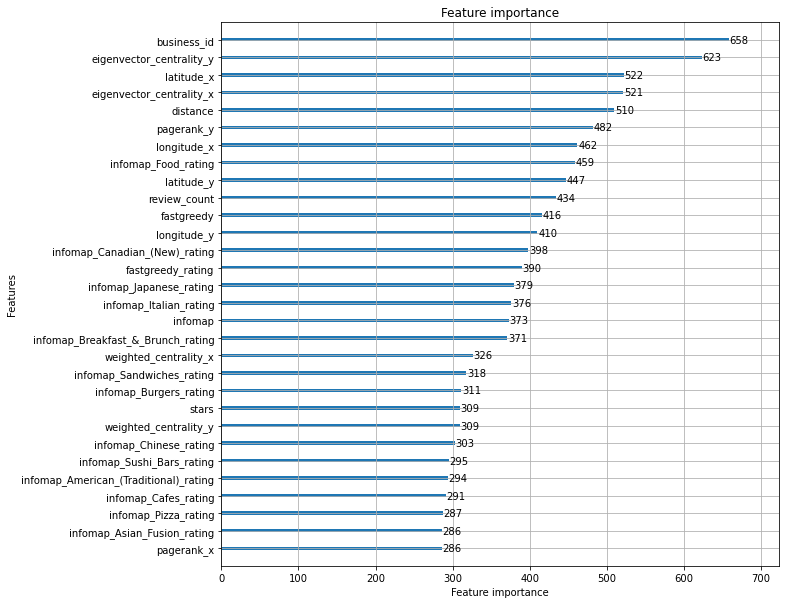

In [128]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)

## 2.2 Rating Predictions

In [24]:
# Create X and y
cols_drop = ['rating', 'set', 'latitude_y', 'latitude_y', 'latitude_x', 'latitude_x']
X_train = data_train.drop(cols_drop, axis=1)
y_train = data_train['rating']

X_val = data_val.drop(cols_drop, axis=1)
y_val = data_val['rating']

X_test = data_test.drop(cols_drop, axis=1)
y_test = data_test['rating']

print('The number of features:', X_train.shape[1])

The number of features: 113


In [50]:
model = lgbm.LGBMRegressor(n_estimators=300, n_jobs=-1, learning_rate=0.001, silent=True)

In [51]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
y_test_hat = model.predict(X_test)

print('Training Mean Absolute Error:', mean_absolute_error(y_train_hat, y_train))
print('Validation Mean Absolute Error:', mean_absolute_error(y_val_hat, y_val))
print('Test Mean Absolute Error:', mean_absolute_error(y_test_hat, y_test))

Training Mean Absolute Error: 0.8752819045292287
Validation Mean Absolute Error: 0.9299636670543349
Test Mean Absolute Error: 0.9292124406458396


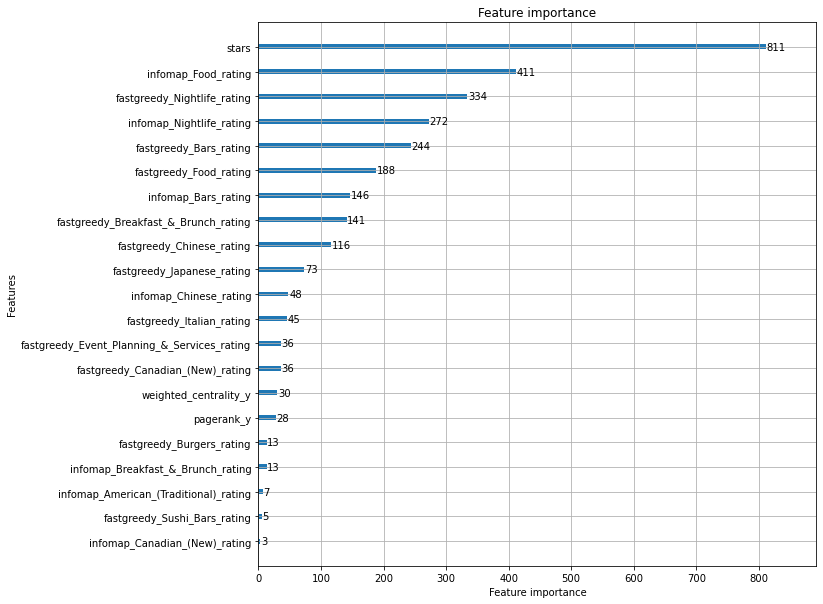

In [49]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)